In [1]:
# to make import as we would be in root directory
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

from lib.autoencoders import TestAutoencoder
import lib.training as training
import lib.utils as utils

c:\Users\Lukasz\anaconda3\envs\un7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%load_ext autoreload

In [10]:
%autoreload

## Loading training dataset

In [11]:
emnist_pages, kmnist_pages, labels = training.load_dataset_pages('clean', 36)

In [13]:
emnist_pages = 1 - emnist_pages
kmnist_pages = 1 - kmnist_pages

In [6]:
emnist_chars = rearrange(emnist_pages, 'p (H h) (W w) -> (p H W) h w', h=32, w=32)
kmnist_chars = rearrange(kmnist_pages, 'p (H h) (W w) -> (p H W) h w', h=32, w=32)

In [15]:
%autoreload
fil_emnist_chars, fil_kmnist_chars, fil_labels = training.filter_white_characters(
    emnist_chars, kmnist_chars, labels, threshold=0.1)

Dropped 67.2% characters
Incorrectly removed characters: 0
Whitespaces missed: 0


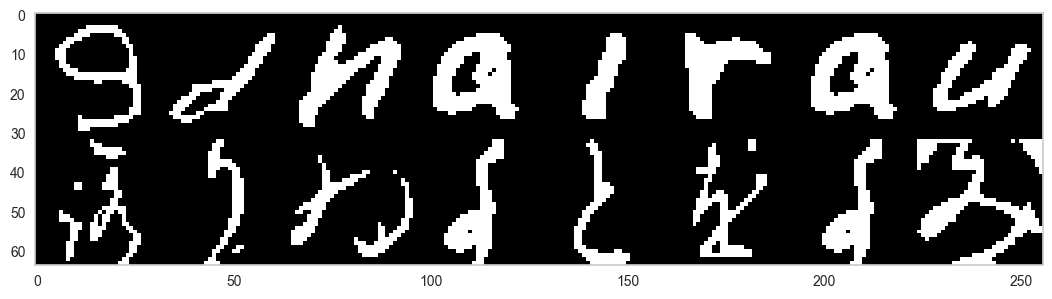

In [16]:
training.show_datasets(fil_emnist_chars, fil_kmnist_chars, samples_count=8)

## EMNIST

In [17]:
emnist_autoencoder = TestAutoencoder('clean_autoencoder_emnist', output_features=30)

In [11]:
# training
emnist_autoencoder.model.fit(fil_emnist_chars, fil_emnist_chars, epochs=2, batch_size=64)

Epoch 1/2
1682/1682 [==============================] - 18s 9ms/step - loss: 0.0030
Epoch 2/2
1682/1682 [==============================] - 14s 8ms/step - loss: 2.5199e-04


In [248]:
emnist_autoencoder.save()

In [18]:
emnist_autoencoder.load()

In [ ]:
utils.visualize_clusters_learned_by_autoencoder(emnist_autoencoder);

1/1 [==============================] - 0s 101ms/step


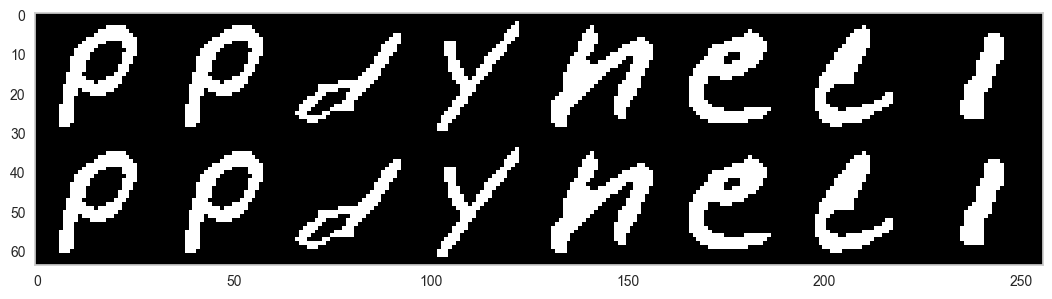

In [19]:
training.test_autoencoder(emnist_autoencoder, fil_emnist_chars, samples_count=8, binarize=True)

In [20]:
encoded_emnist = emnist_autoencoder.encoder.predict(fil_emnist_chars, batch_size=64)

1682/1682 [==============================] - 3s 2ms/step


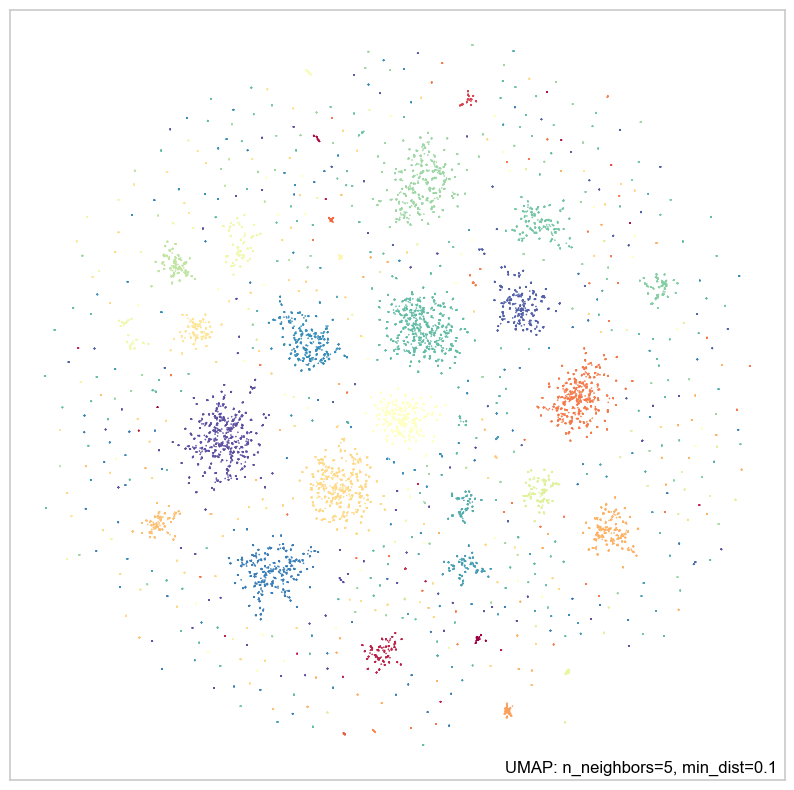

In [23]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.visualize_clusters(encoded_emnist, ax, labels=fil_labels, n_samples=20_000)

Clusters count: 34


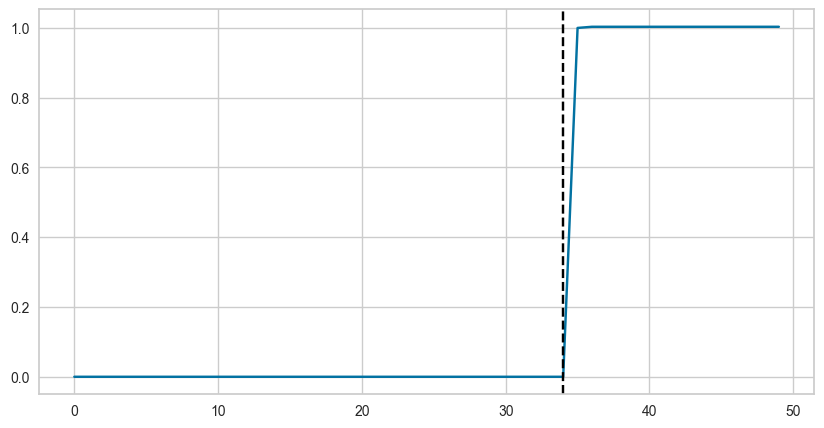

In [25]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
emnist_clusters_no = utils.get_number_of_clusters_with_eigen_values(encoded_emnist, ax, n_samples=3_000)
print('Clusters count:', emnist_clusters_no)

In [99]:
emnist_clusters_no = 37

In [100]:
sampled_encoded_emnist, sampled_fil_labels = utils.sample(encoded_emnist, fil_labels, n=15_000)
emnist_labels = utils.cluster(sampled_encoded_emnist, emnist_clusters_no)
sorted_encoded_emnist, sorted_labels = utils.sort_characters_by_labels(sampled_encoded_emnist, sampled_fil_labels, emnist_labels)

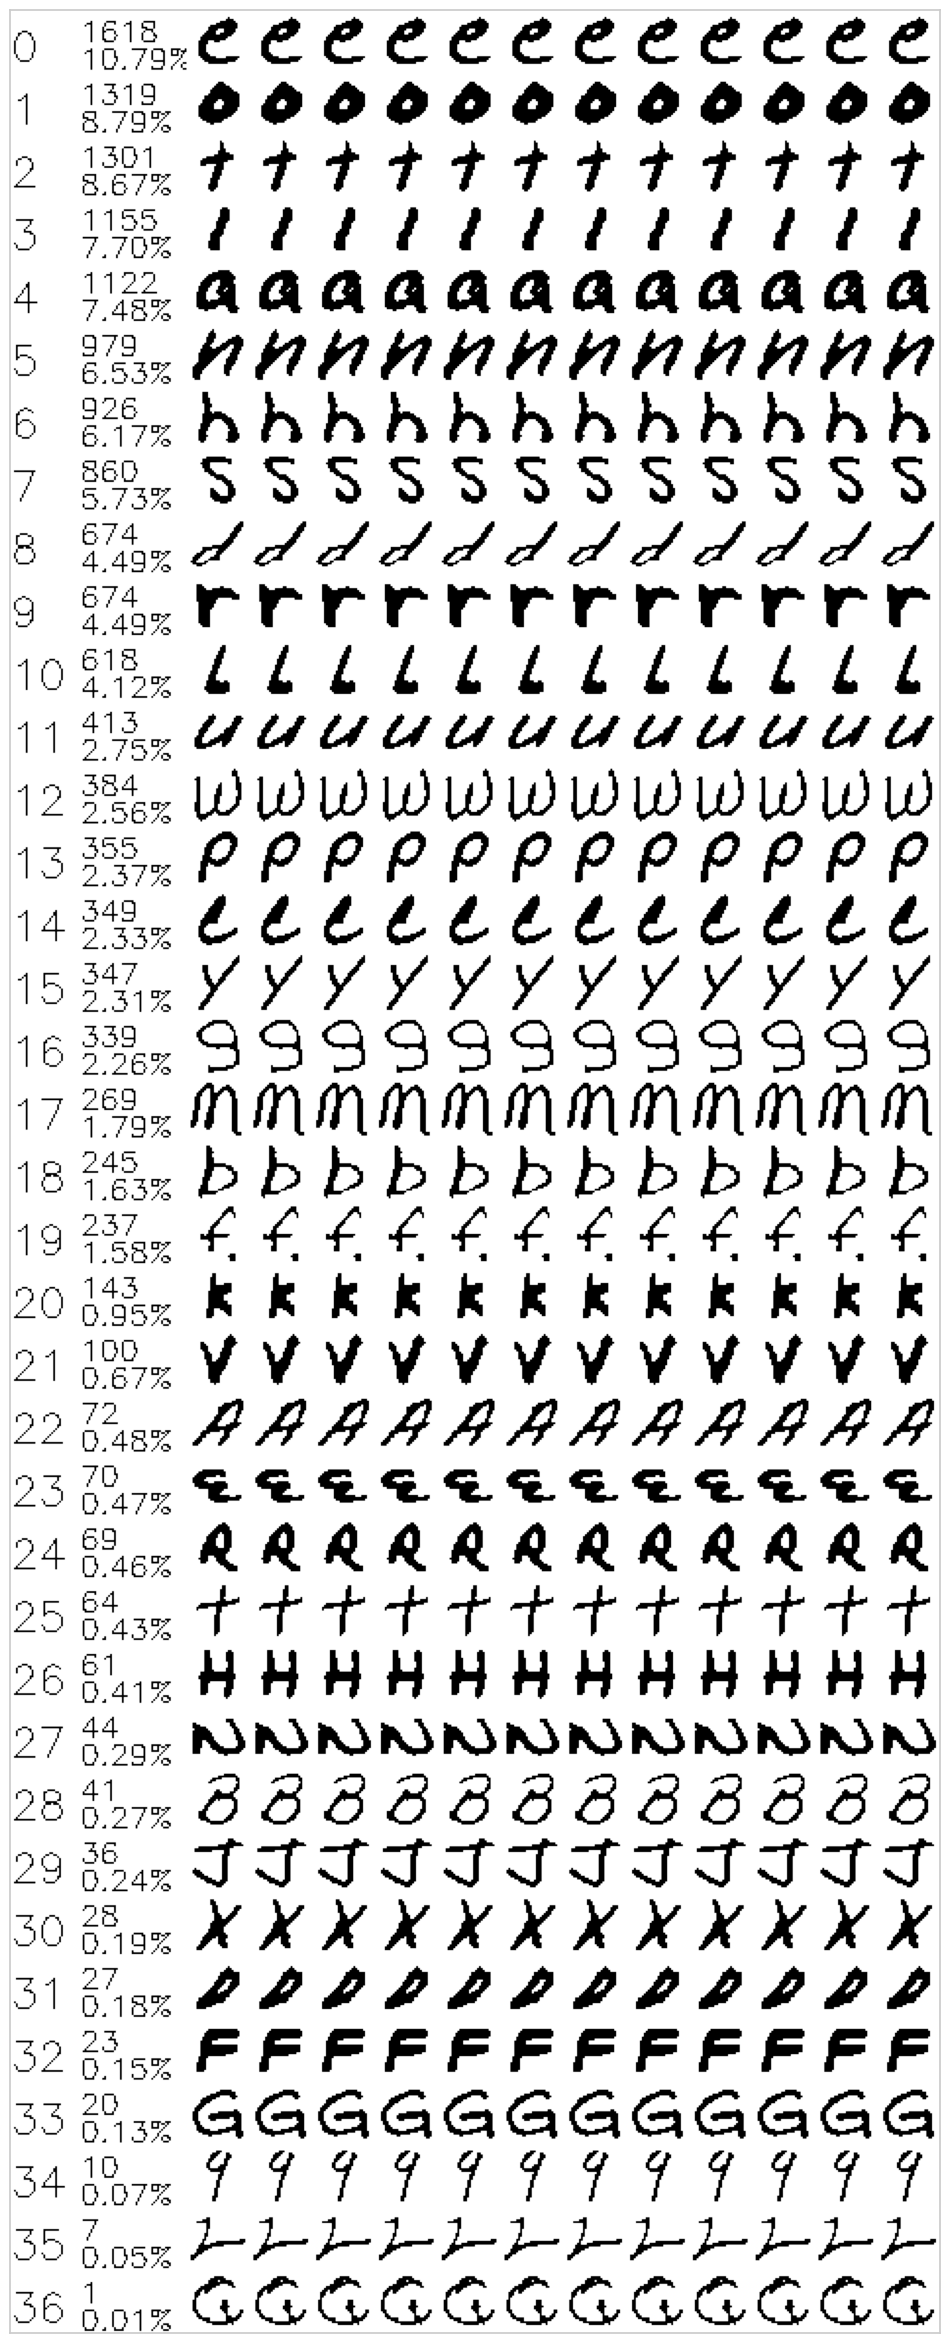

In [101]:
utils.visualize_sorted_characters(sorted_encoded_emnist, emnist_autoencoder, binarize=True);

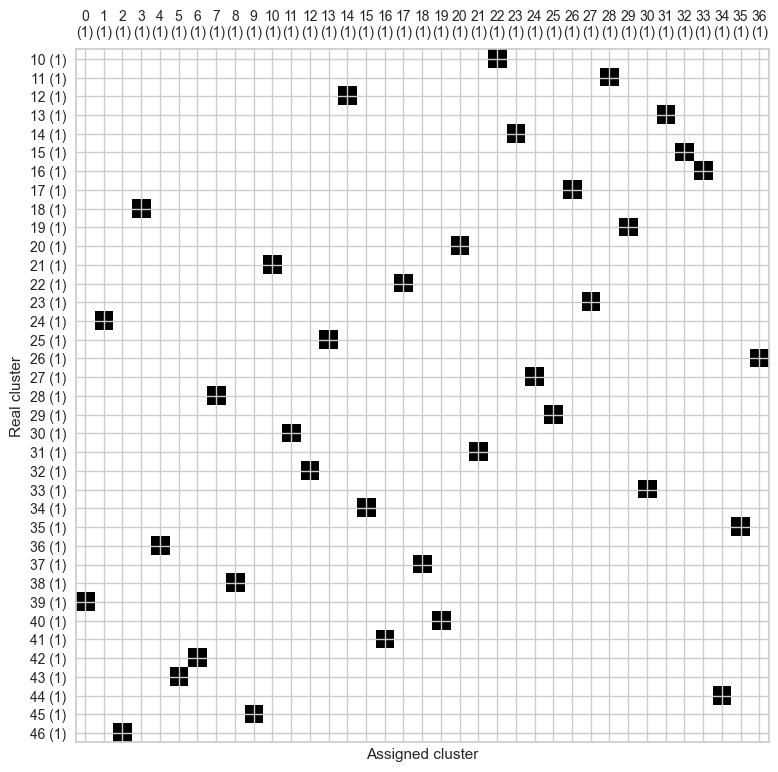

In [102]:
utils.show_clusters_consistency_matrix(sorted_labels)

2023-01-10 21:50:58.297 INFO    matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-01-10 21:50:58.299 INFO    matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


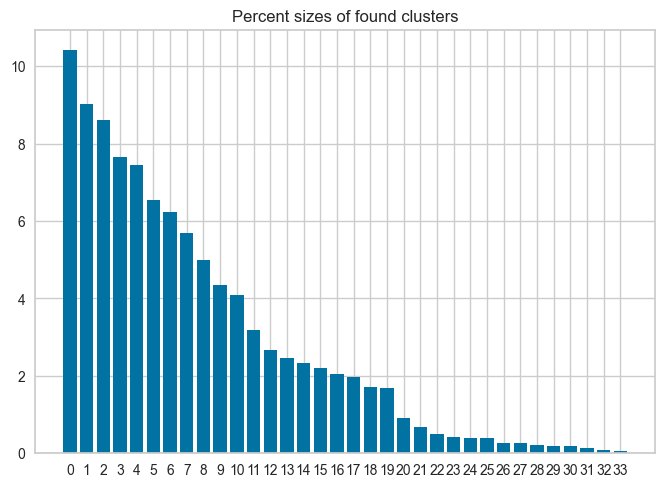

In [27]:
emnist_clusters_sizes = [len(class_characters) for class_characters in sorted_encoded_emnist]
emnist_clusters_percents = np.array(emnist_clusters_sizes) / sum(emnist_clusters_sizes) * 100

plt.bar([str(x) for x in range(len(emnist_clusters_sizes))], emnist_clusters_percents)
plt.title('Percent sizes of found clusters');

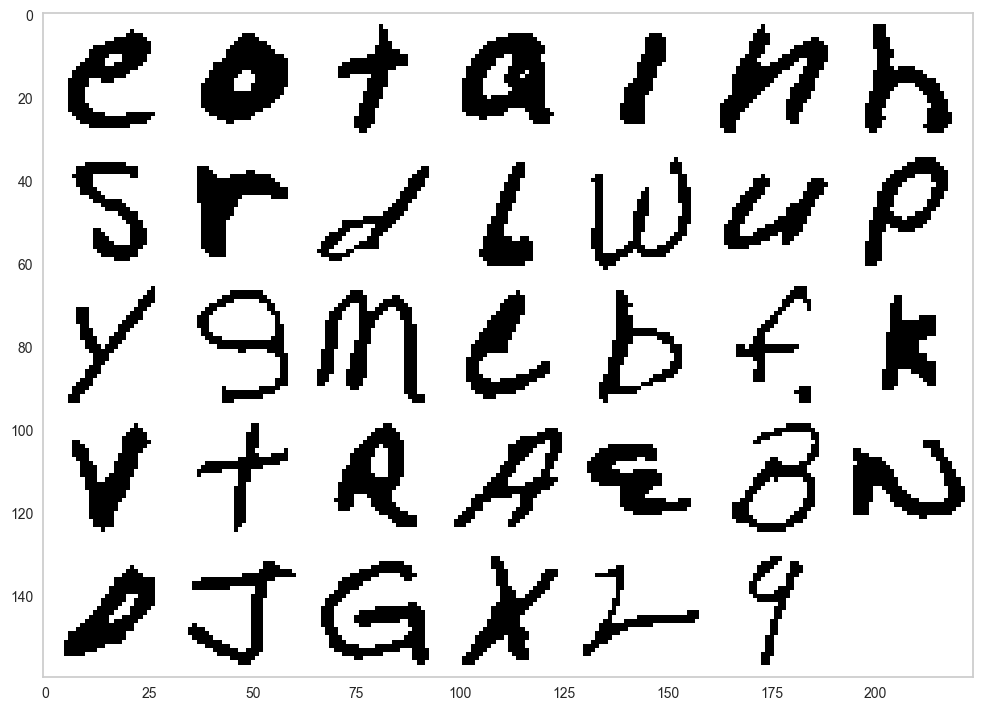

In [42]:
emnist_representatives = training.create_characters_representatives(sorted_encoded_emnist, emnist_autoencoder)
training.show_characters_representatives(emnist_representatives)

In [ ]:
emnist_autoencoder.quantities = emnist_clusters_sizes
emnist_autoencoder.characters = emnist_representatives
emnist_autoencoder.save()

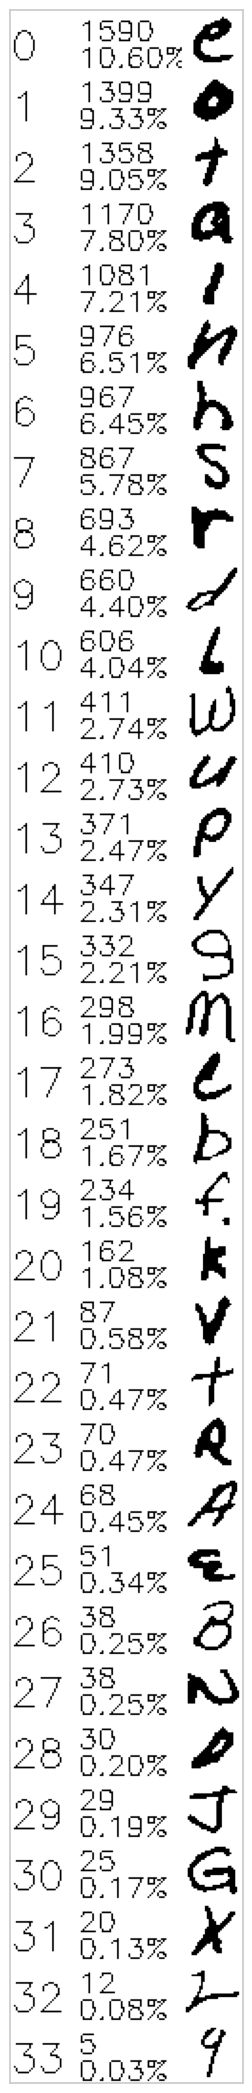

In [46]:
utils.visualize_clusters_learned_by_autoencoder(emnist_autoencoder);

## KMNIST

In [8]:
kmnist_autoencoder = TestAutoencoder('clean_autoencoder_kmnist', output_features=30)

In [ ]:
# training
kmnist_autoencoder.model.fit(fil_kmnist_chars, fil_kmnist_chars, epochs=2, batch_size=64)

In [ ]:
kmnist_autoencoder.save()

In [9]:
kmnist_autoencoder.load()

In [ ]:
utils.visualize_clusters_learned_by_autoencoder(kmnist_autoencoder);

1/1 [==============================] - 0s 121ms/step


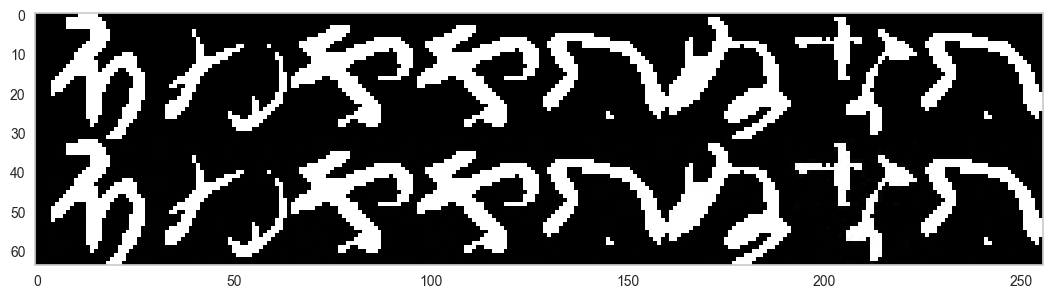

In [12]:
training.test_autoencoder(kmnist_autoencoder, fil_kmnist_chars, samples_count=8)

In [10]:
encoded_kmnist = kmnist_autoencoder.encoder.predict(fil_kmnist_chars, batch_size=256)

421/421 [==============================] - 1s 2ms/step


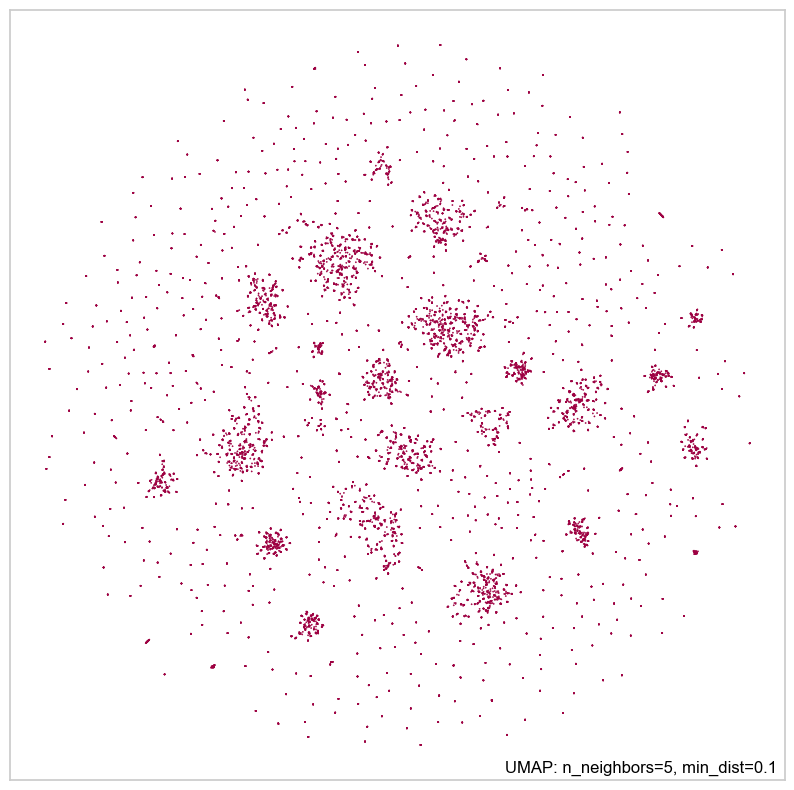

In [11]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.visualize_clusters(encoded_kmnist, ax, n_samples=15_000)

Clusters count: 34


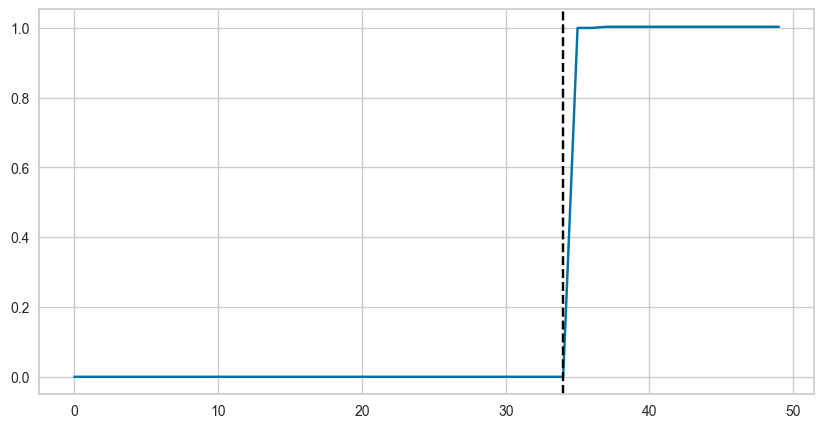

In [12]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
kmnist_clusters_no = utils.get_number_of_clusters_with_eigen_values(encoded_kmnist, ax, n_samples=3_000)
print('Clusters count:', kmnist_clusters_no)

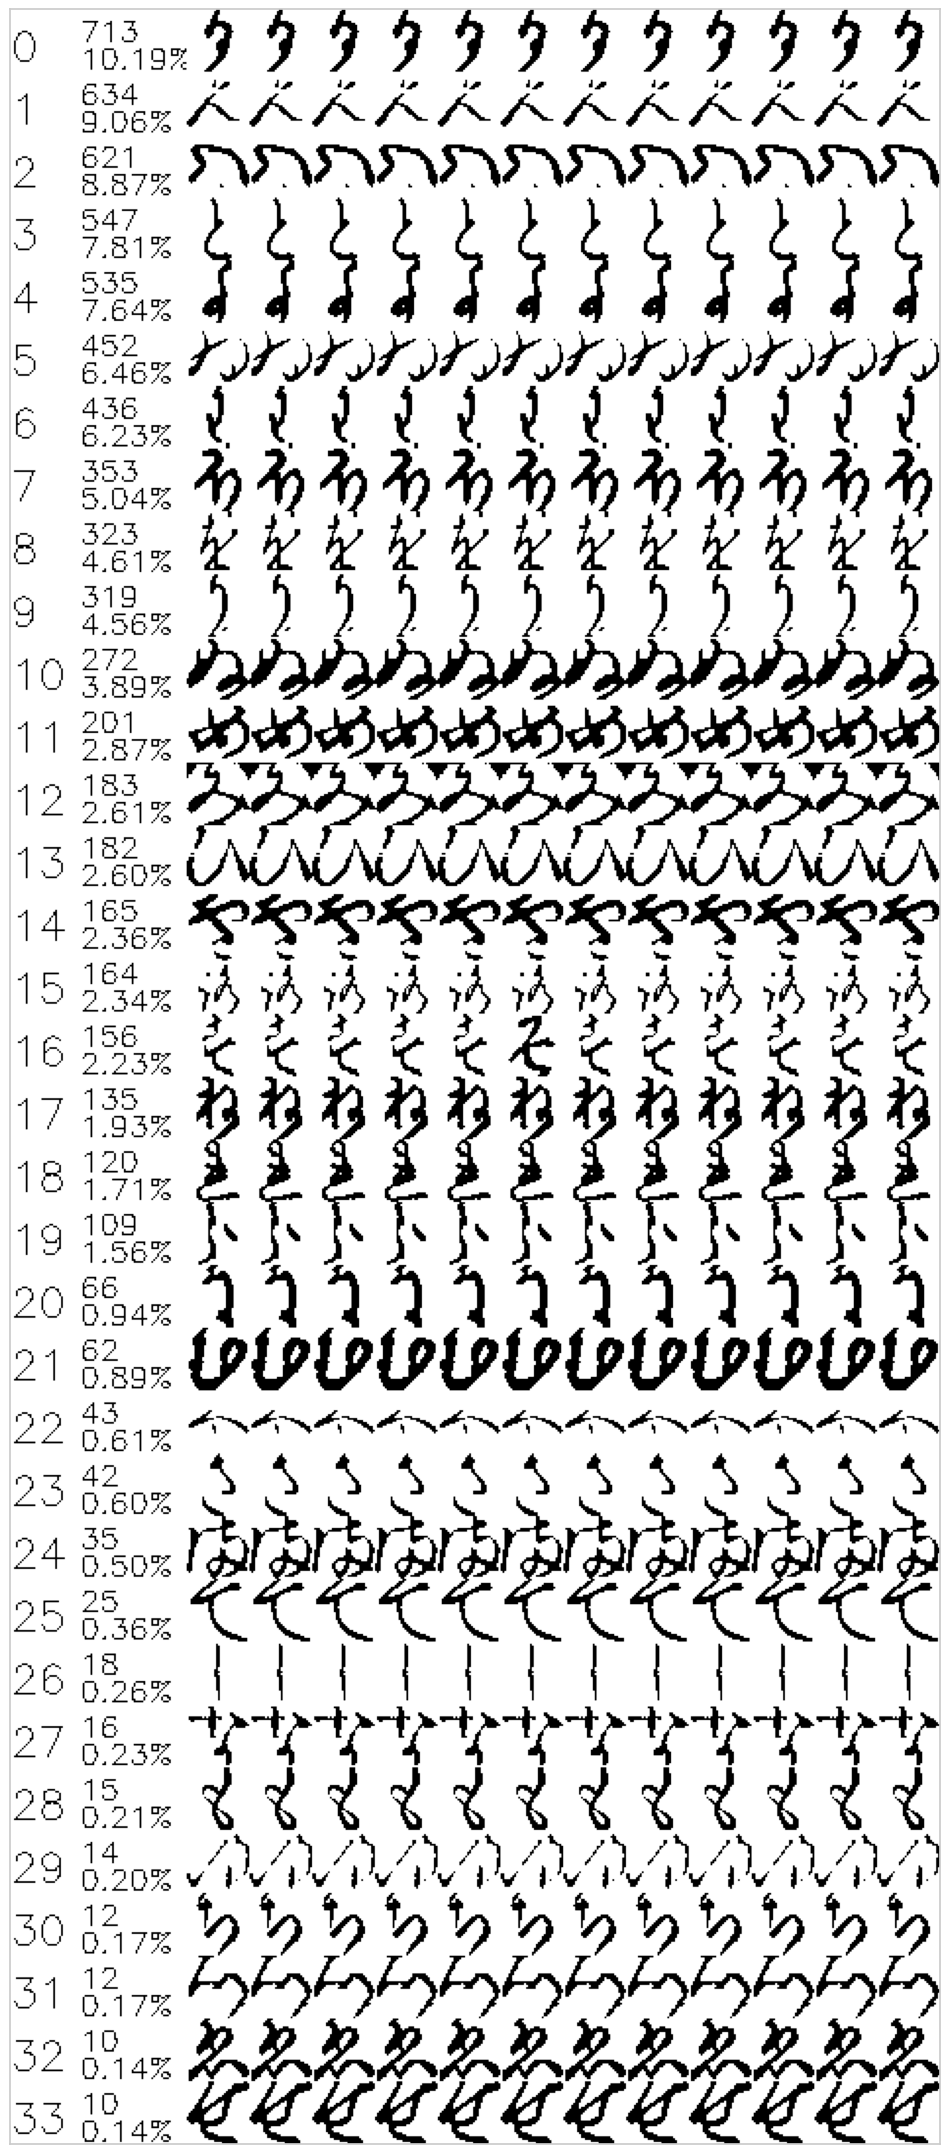

In [13]:
sampled_encoded_kmnist = utils.sample(encoded_kmnist, n=7_000)
kmnist_labels = utils.cluster(sampled_encoded_kmnist, kmnist_clusters_no)
sorted_encoded_kmnist = utils.sort_characters_by_labels(sampled_encoded_kmnist, kmnist_labels)
_ = utils.visualize_sorted_characters(sorted_encoded_kmnist, kmnist_autoencoder, binarize=True)

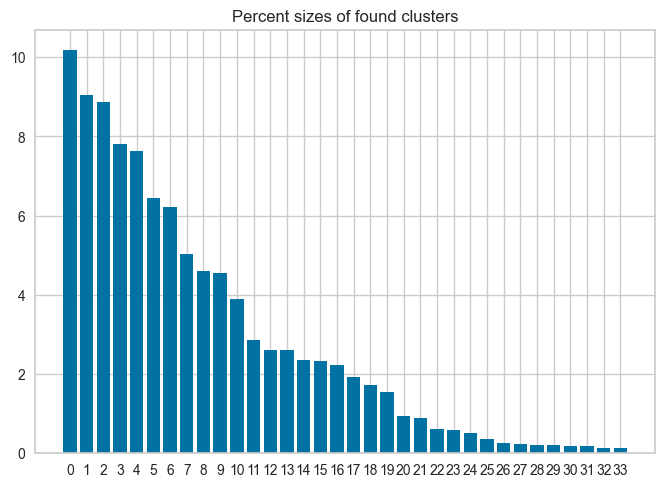

In [15]:
kmnist_clusters_sizes = [len(class_characters) for class_characters in sorted_encoded_kmnist]
kmnist_clusters_percents = np.array(kmnist_clusters_sizes) / sum(kmnist_clusters_sizes) * 100

plt.bar([str(x) for x in range(len(kmnist_clusters_percents))], kmnist_clusters_percents)
plt.title('Percent sizes of found clusters');

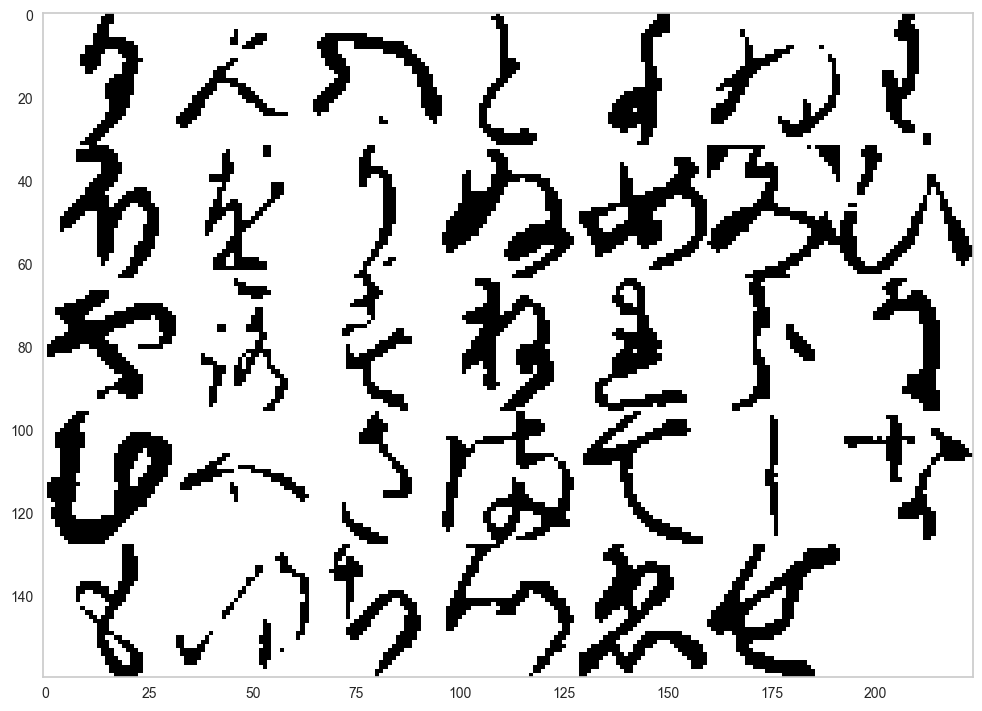

In [14]:
kmnist_representatives = training.create_characters_representatives(sorted_encoded_kmnist, kmnist_autoencoder)
training.show_characters_representatives(kmnist_representatives)

In [44]:
kmnist_autoencoder.quantities = kmnist_clusters_sizes
kmnist_autoencoder.characters = kmnist_representatives
kmnist_autoencoder.save()

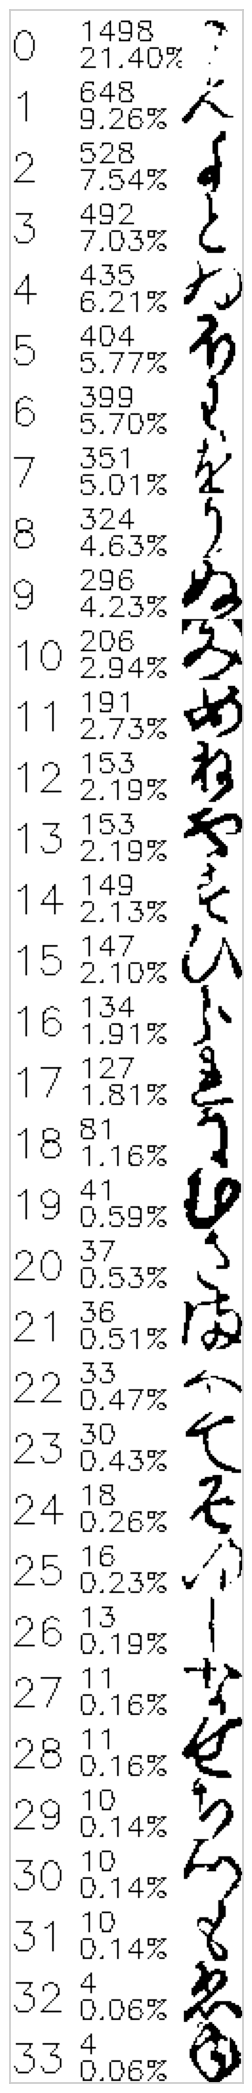

In [45]:
utils.visualize_clusters_learned_by_autoencoder(kmnist_autoencoder);